# Traffic information Netherlands
The intention of this Python script is to scrape actual travel information about expected delays.
The first part will do this for traffic, the second part can do this for trains.

Source: https://www.anwb.nl/feeds/gethf

### Init all necessary libraries

In [15]:
# Load packages into memory
import urllib
import requests
import json
import pandas as pd
import seaborn as sns

from pandas.io.json import json_normalize
from sqlalchemy import create_engine
from datetime import datetime

### Execute call to webservice

In [2]:
# Let's get the current VAT rate in the EU
url = 'https://www.anwb.nl/feeds/gethf'
routeInfo = requests.get(url, headers={})

### Translate JSON data into dataframe

In [3]:
# Pandas version 0.25 contains new parameter max_level in json_normalize.
pd.__version__

'0.25.1'

In [4]:
# Create json object from returned text
jso = json.loads(routeInfo.text)

In [5]:
# Create dataframe from json object roadEntries
trafficdf = json_normalize(jso['roadEntries'])

# Drop unnecessary columns (I did not find any documentation about the webservice yet to only retrieve what I need.)
trafficdf.drop(columns = ['events.roadWorks','events.radars'],inplace=True)

# Read the number of trafficJams and filter the dataframe on it.
trafficdf['listlength'] = trafficdf['events.trafficJams'].apply(lambda x : len(x))
trafficdf = trafficdf[trafficdf['listlength'] > 0]
trafficdf.drop(columns = ['listlength'], inplace=True)
trafficdf['timestap'] = datetime.now()

# Pop all trafficjams, normalize and join back to dataframe to keep road info.
trafficdf = (pd.concat({i: json_normalize(x) for i, x in trafficdf.pop('events.trafficJams').items()}, sort=True)
         .reset_index(level=1, drop=True)
         .join(trafficdf)
         .reset_index(drop=True))

# Drop all items where no delays are mentioned.
trafficdf = trafficdf.dropna()
trafficdf.drop(columns=['events'],inplace=True)

# Set index to msgNr.
#trafficdf.set_index('msgNr', inplace=True)

trafficdf.tail()

,delay,description,distance,from,fromLoc.lat,fromLoc.lon,location,msgNr,reason,segEnd,segStart,start,startDate,to,toLoc.lat,toLoc.lon,road,roadType,timestap
6,1740.0,Tussen Nieuwegein en Maarssen. Door een ongeluk.,5300.0,Nieuwegein,52.02208,5.06477,A2 's-Hertogenbosch richting Amsterdam,200621585,Door een ongeluk.,Amsterdam,'s-Hertogenbosch,2019-09-08T08:51:00,8 September 2019 10:51 uur,Maarssen,52.11816,5.03346,A2,aWegen,2019-09-08 14:27:27.890315
10,60.0,Tussen Amsterdam-Hemhavens en knp. Coenplein. ...,2100.0,Amsterdam-Hemhavens,52.40446,4.85347,A10 knp. De Nieuwe Meer richting knp. Watergra...,200621582,Spoedreparatie.,knp. Watergraafsmeer,knp. De Nieuwe Meer,2019-09-08T09:36:00,8 September 2019 11:36 uur,knp. Coenplein,52.42345,4.87788,A10,aWegen,2019-09-08 14:27:27.890315
12,480.0,Tussen Rotterdam-Overschie en Delft.,8600.0,Rotterdam-Overschie,51.93663,4.43231,A13 Rotterdam richting Den Haag,200621590,,Den Haag,Rotterdam,2019-09-08T11:45:00,8 September 2019 13:45 uur,Delft,52.01124,4.37786,A13,aWegen,2019-09-08 14:27:27.890315
13,360.0,Tussen de Belgische grens en knp. Galder.,3400.0,de Belgische grens,51.48681,4.73593,A16 Antwerpen richting Breda,200621592,,Breda,Antwerpen,2019-09-08T08:36:30,8 September 2019 10:36 uur,knp. Galder,51.52700,4.74425,A16,aWegen,2019-09-08 14:27:27.890315
20,900.0,Tussen de aansluiting met de A6 en afrit Enkhu...,2500.0,de aansluiting met de A6,52.54916,5.51420,N307 Lelystad - Lelystad,200621588,,Lelystad,Lelystad,2019-09-08T11:46:00,8 September 2019 13:46 uur,afrit Enkhuizen-Centrum,52.69542,5.27667,N307,nWegen,2019-09-08 14:27:27.890315


### Push dataframe to local sql db

In [6]:
engine = create_engine('sqlite:///traffic.db', echo=False)

#%time trafficdf.to_sql(name='TrafficInformation',con=engine, if_exists='append', index=False)

try:
    #this will fail if there is a new column
    trafficdf.to_sql(name='TrafficInformation', con=engine, if_exists = 'append', index=False)
except:
    print('Dataconversion necessary for table...')
    existingdata = pd.read_sql_query('SELECT * FROM TrafficInformation', con=engine)
    df2 = pd.concat([existingdata,trafficdf], sort=True)
    df2.to_sql(name='TrafficInformation', con=engine, if_exists = 'replace', index=False)


### Read trafficinfo from db beloning to scheduled task

In [37]:
engine = create_engine('sqlite:///C:\\PythonLearning\\Data\\traffic.db', echo=False)
dftest = pd.read_sql_query(sql="SELECT * FROM TrafficInformation", con=engine)
dftest.tail()

,delay,description,distance,from,fromLoc.lat,fromLoc.lon,location,msgNr,reason,segEnd,segStart,start,startDate,to,toLoc.lat,toLoc.lon,road,roadType,timestap
109,300.0,Tussen de Belgische grens en knp. Galder.,3200.0,de Belgische grens,51.48681,4.73593,A16 Antwerpen richting Breda,200625114,,Breda,Antwerpen,2019-09-08T08:36:30,8 september 2019 10:36 uur,knp. Galder,51.52700,4.74425,A16,aWegen,2019-09-08 14:51:13.797219
110,300.0,Tussen Schiedam-Noord en Rotterdam-Overschie.,2800.0,Schiedam-Noord,51.92584,4.37372,A20 Hoek van Holland richting Gouda,200625116,,Gouda,Hoek van Holland,2019-09-08T11:20:00,8 september 2019 13:20 uur,Rotterdam-Overschie,51.92963,4.43443,A20,aWegen,2019-09-08 14:51:13.797219
111,180.0,Tussen Hilversum en knp. Eemnes.,2700.0,Hilversum,52.20084,5.19207,A27 Utrecht richting Almere,200625126,,Almere,Utrecht,2019-09-08T12:30:00,8 september 2019 14:30 uur,knp. Eemnes,52.23200,5.23886,A27,aWegen,2019-09-08 14:51:13.797219
112,1320.0,Tussen de aansluiting met de A6 en Lelystad.,2900.0,de aansluiting met de A6,52.54916,5.51420,N307 Lelystad - Kampen,200625110,,Kampen,Lelystad,2019-09-08T11:46:00,8 september 2019 13:46 uur,Lelystad,52.52581,5.44318,N307,nWegen,2019-09-08 14:51:13.797219
113,480.0,"Oliemolensingel/Boddenkampsingel, tussen de B...",2200.0,de Boulevard 1945,52.21688,6.91094,"Oliemolensingel/Boddenkampsingel,",200625118,,Parkweg,Gronausestraat,2019-09-08T12:24:00,8 september 2019 14:24 uur,de Deurningerstraat,52.22848,6.88990,Enschede,overige,2019-09-08 14:51:13.797219


In [38]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 19 columns):
delay          114 non-null float64
description    114 non-null object
distance       114 non-null float64
from           114 non-null object
fromLoc.lat    114 non-null float64
fromLoc.lon    114 non-null float64
location       114 non-null object
msgNr          114 non-null object
reason         114 non-null object
segEnd         114 non-null object
segStart       114 non-null object
start          114 non-null object
startDate      114 non-null object
to             114 non-null object
toLoc.lat      114 non-null float64
toLoc.lon      114 non-null float64
road           114 non-null object
roadType       114 non-null object
timestap       114 non-null object
dtypes: float64(6), object(13)
memory usage: 17.0+ KB


Text(0.5, 1.0, 'Actual Delays')

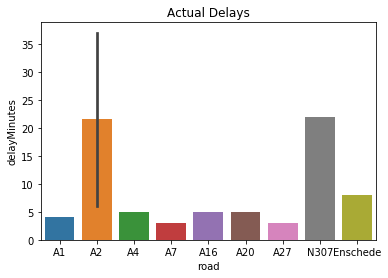

In [39]:
latestTimestamp = dftest.timestap.max()
#dftest[dftest['timestap']==latestTimestamp].plot(x='start',y='delay')
#dftest.plot(x='timestap',y='delay')
dftest['delayMinutes'] = dftest['delay'] / 60
bp = sns.barplot(x='road',y='delayMinutes',data=dftest[dftest['timestap']==latestTimestamp])
#bp.set_xticklabels(bp.get_xticklabels(), rotation=90)
bp.set_title('Actual Delays')

### Push dataframe to Azure SQL, based on index

params = 'DRIVER={SQL Server};' \
         'SERVER=****;' \
         'PORT=1433;' \
         'DATABASE=o365data;' \
         'UID=****;' \
         'PWD=****;'
            
params = urllib.parse.quote_plus(params)

engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

%time trafficdf.to_sql(name='TrafficInformation',con=engine , schema='dbo', if_exists='append', index=False)